# Импортирование библиотек

In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import numpy as np
import numpy.ma as ma

import pyproj

from scipy import stats as st
from scipy.stats.mstats import gmean, hmean
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import geopandas as gpd
import pandas as pd
import fiona
from fiona.drvsupport import supported_drivers
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely import affinity

from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pylab as plt
from math import e

import seaborn as sns
import cv2

from pathlib import Path as fpath

np.seterr(divide='ignore', invalid='ignore')

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

## Загрузка реальных данных о пастбище в формате .jp2
## дата: 2022/08/03

In [2]:
date = "20220803/R10m"
bands_name = []
bands_dict = {}
bands = glob(f"./Pasture_Images/dates/{date}/*B?*.jp2")
if (not bands):
    bands = glob(f"./Pasture_Images/dates/{date}/*B?*.tif")
bands.sort()

for i, band in enumerate(bands):
    bands_dict[fpath(band).name[-11:-8]] = i
    bands_name.append(fpath(band).name[-11:-8])
    print("Номер:", i, "Канал:", fpath(band).name[-11:-8])
    file_extention = fpath(band).suffix

Номер: 0 Канал: B02
Номер: 1 Канал: B03
Номер: 2 Канал: B04
Номер: 3 Канал: B08


# Формирование стэка (3-х мерной матрицы) изображении

In [3]:
layers = []
for band in bands:
  with rio.open(band, 'r') as file_image:
    raster_profile = file_image.profile
    raster_crs = file_image.profile["crs"]
    raster_driver = file_image.profile["driver"]
    layers.append(file_image.read(1))

In [4]:
sorter = lambda x: len(x)
sorted_layers = sorted(layers, key=sorter, reverse=True)
largest_dimensionH = sorted_layers[0].shape[0]
largest_dimensionW = sorted_layers[0].shape[1]

#                  *                 0                  1 
# np.shape --> [layers]*, rows (height)(высота), cols (width)(ширина)

print("Наибольший размер (разрешение) изображения")
print("Высота:", largest_dimensionH, "Ширина:", largest_dimensionW)

Наибольший размер (разрешение) изображения
Высота: 10980 Ширина: 10980


### Разбивка изображении (приведение в один размер) 

In [5]:
try:
    bands_stack = np.stack(layers)
except:
    reshaped_layer = []
    for band, layer in enumerate(layers):
        if (layer.shape[0] < largest_dimensionH or layer.shape[1] < largest_dimensionW):
            print()
            print("Канал:", bands_name[band], "|| Разрешение на входе:", layer.shape, "-->> ", end="")
            new_layer = cv2.resize(layer, dsize=(largest_dimensionW, largest_dimensionH), interpolation=cv2.INTER_CUBIC)
            print("Разрешение на выходе:", new_layer.shape)
            reshaped_layer.append(new_layer)
        else:
            print()
            print("Канал:", bands_name[band], "|| Не требует преобразовании:", layer.shape)
            reshaped_layer.append(layer)
    bands_stack = np.stack(reshaped_layer)
    
image_width, image_height = bands_stack.shape[1], bands_stack.shape[2]

# Обрезка изображении по GPS координатам

In [6]:
supported_drivers['KML'] = 'rw'
tile_id = "42UWF"

if (raster_driver == "GTiff"):
    pasture_df = gpd.read_file('pasture.kml', driver='KML').to_crs("EPSG:3857")
    global_df = gpd.read_file('global.kml', driver='KML').to_crs("EPSG:3857")
if (raster_driver == "JP2OpenJPEG"):    
    pasture_df = gpd.read_file('pasture.kml', driver='KML').to_crs(raster_crs)
    global_df = gpd.read_file('global.kml', driver='KML').to_crs(raster_crs)

T42UWF = global_df[global_df["Name"] == tile_id].reset_index(0, True)
T42UWF = T42UWF.iloc[0]

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_17596\2559536673.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.reset_index except for the argument 'level' will be keyword-only.
  T42UWF = global_df[global_df["Name"] == tile_id].reset_index(0, True)


In [7]:
all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)

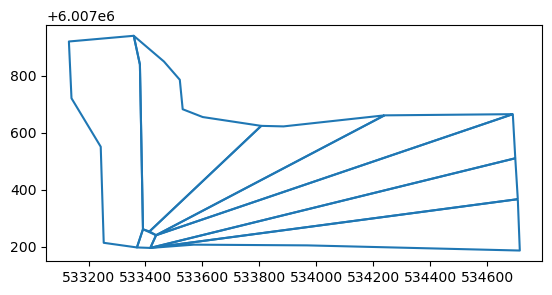

In [8]:
gpd.GeoSeries(all_zagons).boundary.plot()
plt.show()

In [9]:
merged_zagons = unary_union(all_zagons)

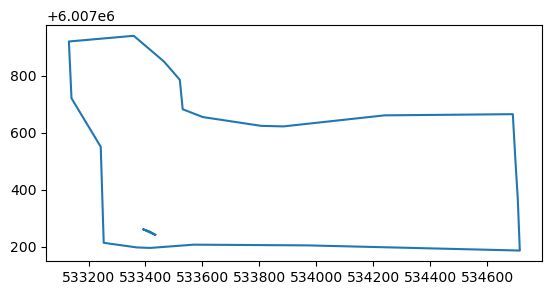

In [10]:
gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

### Крайние точки пастбища и глобального квадрата (мозайки)

In [11]:
x_min, y_min, x_max, y_max = merged_zagons.bounds 
X_min, Y_min, X_max, Y_max = T42UWF.geometry.bounds

# Конвертация

In [12]:
x_axis_cut1 = int(np.interp(x_min, [X_min, X_max], [0, bands_stack.shape[2]])) # Левая грань
x_axis_cut2 = int(np.interp(x_max, [X_min, X_max], [0, bands_stack.shape[2]])) # Правая грань
y_axis_cut1 = int(np.interp(y_max, [Y_min, Y_max], [bands_stack.shape[1], 0])) # Нижняя грань
y_axis_cut2 = int(np.interp(y_min, [Y_min, Y_max], [bands_stack.shape[1], 0])) # Вверняя грань

print("Параметры изображения-обрезки")
print("Ширина:", x_axis_cut2 - x_axis_cut1)
print("Высота:", y_axis_cut2 - y_axis_cut1)

Параметры изображения-обрезки
Ширина: 158
Высота: 76


# Вывод изображения-обрезки пастбища 

### aoi - (area of interest) = Область интереса (пастбище)

In [13]:
if (raster_driver == "GTiff"):
    x_corr_shift = 13
    y_corr_shift = 9
    aoi_bands_stack = bands_stack[:, y_axis_cut1-y_corr_shift:y_axis_cut2-y_corr_shift, x_axis_cut1-x_corr_shift:x_axis_cut2-x_corr_shift]
if (raster_driver == "JP2OpenJPEG"): 
    aoi_bands_stack = bands_stack[:, y_axis_cut1:y_axis_cut2, x_axis_cut1:x_axis_cut2]

# Все 13 каналов

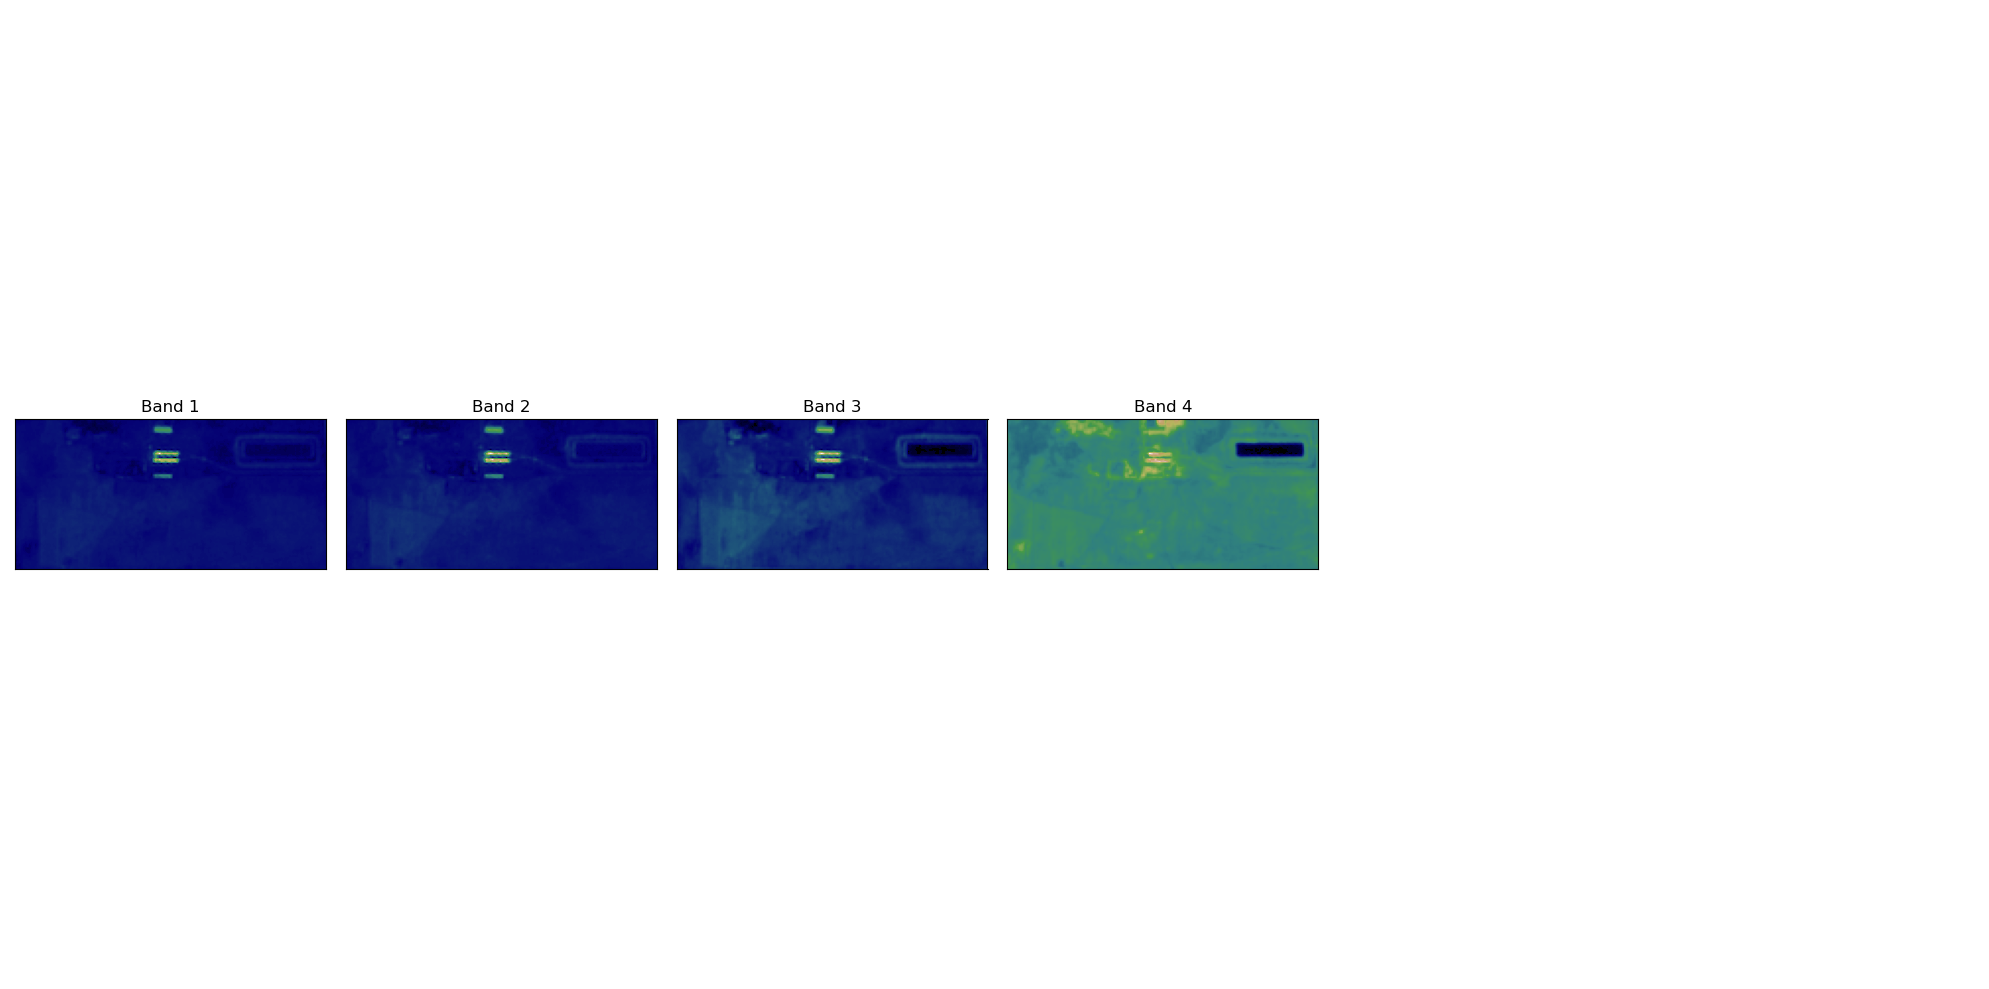

In [14]:
ep.plot_bands(aoi_bands_stack, 
              cmap = 'gist_earth', 
              figsize = (20, 10), 
              cols = 6, 
              cbar = False)
plt.show()

# Реальное RGB изображение пастбища с коррекцией

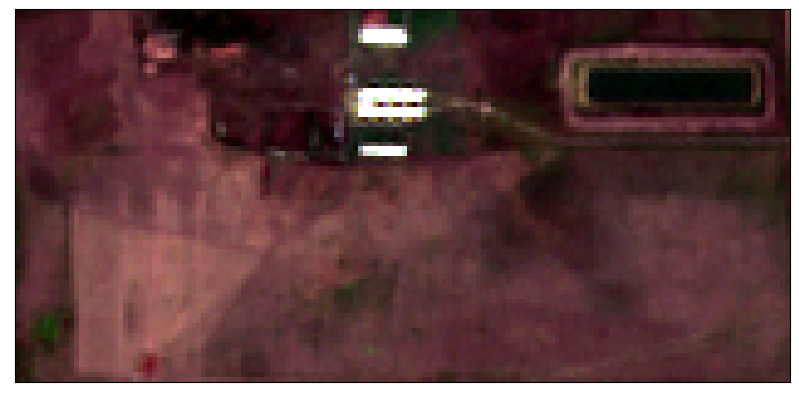

In [15]:
ep.plot_rgb(aoi_bands_stack,
            rgb=(bands_dict["B04"], bands_dict["B03"], bands_dict["B02"]),
            stretch=True,
            str_clip=0.8,
            figsize=(10, 16))
plt.show()

# Создание масок для загонов

In [16]:
aoi_width, aoi_height = aoi_bands_stack.shape[2], aoi_bands_stack.shape[1]

In [17]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)

# Пример одной маски для определенного загона

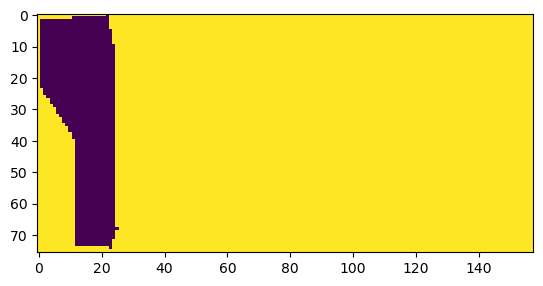

In [18]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Normalized Difference Vegetation Index (NDVI)

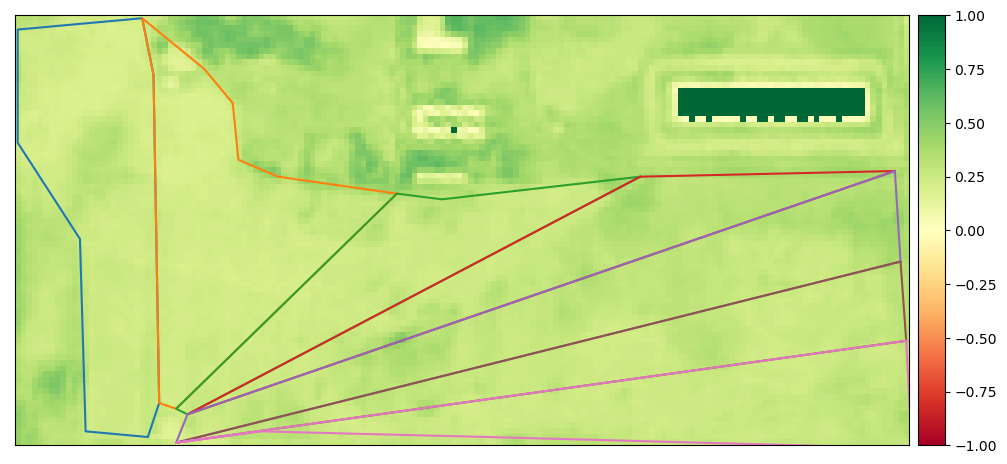

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):
    
    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ndvi = es.normalized_diff(aoi_bands_stack[bands_dict["B08"]], aoi_bands_stack[bands_dict["B04"]])
ep.plot_bands(ndvi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

In [20]:
ndvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndvi, mask=mask.reshape(aoi_height, aoi_width))
    ndvi_masked_array.append(mx)

# Статистические средние значения по загонам 

In [21]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Среднее значение NDVI: ", ndvi_masked_array[zagon].mean(), " --> ", 451.99 * (0.001 * e**(8.7343 * ndvi_masked_array[zagon].mean())) + 1870.7, "кг/га")

Загон №1. Среднее значение NDVI:  0.24002194275082364  -->  1874.3778503271958 кг/га
Загон №2. Среднее значение NDVI:  0.23557113973947308  -->  1874.2376185774615 кг/га
Загон №3. Среднее значение NDVI:  0.2525934588943054  -->  1874.804696577117 кг/га
Загон №4. Среднее значение NDVI:  0.30198322614190826  -->  1877.0187213446359 кг/га
Загон №5. Среднее значение NDVI:  0.29780455133968653  -->  1876.7922597345748 кг/га
Загон №6. Среднее значение NDVI:  0.26640969156220784  -->  1875.331158004194 кг/га
Загон №7. Среднее значение NDVI:  0.2603466114010529  -->  1875.0922875996164 кг/га


In [22]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Медианное значение NDVI: ", ma.median(ndvi_masked_array[zagon]), " --> ", 451.99 * (0.001 * e**(8.7343 * ma.median(ndvi_masked_array[zagon]))) + 1870.7, "кг/га")

Загон №1. Медианное значение NDVI:  0.23578523123040496  -->  1874.2442398983053 кг/га
Загон №2. Медианное значение NDVI:  0.22689149263782568  -->  1873.9793431423361 кг/га
Загон №3. Медианное значение NDVI:  0.24322637782414164  -->  1874.4822418980439 кг/га
Загон №4. Медианное значение NDVI:  0.3042291950886767  -->  1877.1438992814528 кг/га
Загон №5. Медианное значение NDVI:  0.29021129797326434  -->  1876.4013176603032 кг/га
Загон №6. Медианное значение NDVI:  0.26007829608773225  -->  1875.0820061219097 кг/га
Загон №7. Медианное значение NDVI:  0.2539435680959787  -->  1874.85338674073 кг/га


In [23]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Гармоническое среднее значение NDVI: ", hmean(ndvi_masked_array[zagon].reshape(aoi_width * aoi_height)), " --> ", 451.99 * (0.001 * e**(8.7343 * hmean(ndvi_masked_array[zagon].reshape(aoi_width * aoi_height)))) + 1870.7, "кг/га")

Загон №1. Гармоническое среднее значение NDVI:  0.23578493728997124  -->  1874.2442307989634 кг/га
Загон №2. Гармоническое среднее значение NDVI:  0.23028738699883577  -->  1874.0780678396698 кг/га
Загон №3. Гармоническое среднее значение NDVI:  0.24954654752758182  -->  1874.6969005041274 кг/га
Загон №4. Гармоническое среднее значение NDVI:  0.2956320305293099  -->  1876.67774628174 кг/га
Загон №5. Гармоническое среднее значение NDVI:  0.29234742761492477  -->  1876.5086890799591 кг/га
Загон №6. Гармоническое среднее значение NDVI:  0.2634525012329664  -->  1875.2130714746881 кг/га
Загон №7. Гармоническое среднее значение NDVI:  0.25790277218615376  -->  1874.9995267556494 кг/га


In [24]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Геометрическое среднее значение NDVI: ", gmean(ndvi_masked_array[zagon].reshape(aoi_width * aoi_height)), " --> ", 451.99 * (0.001 * e**(8.7343 * gmean(ndvi_masked_array[zagon].reshape(aoi_width * aoi_height)))) + 1870.7, "кг/га")

Загон №1. Геометрическое среднее значение NDVI:  0.23784293166572817  -->  1874.3085148714868 кг/га
Загон №2. Геометрическое среднее значение NDVI:  0.2327067117999399  -->  1874.150209692344 кг/га
Загон №3. Геометрическое среднее значение NDVI:  0.2509664076954014  -->  1874.7467766342324 кг/га
Загон №4. Геометрическое среднее значение NDVI:  0.29876643668583114  -->  1876.8436588258492 кг/га
Загон №5. Геометрическое среднее значение NDVI:  0.2950004096137294  -->  1876.64485924938 кг/га
Загон №6. Геометрическое среднее значение NDVI:  0.26489973234532954  -->  1875.2704812647528 кг/га
Загон №7. Геометрическое среднее значение NDVI:  0.2590855479950179  -->  1875.044174180224 кг/га


# Гистограмма NDVI по загонам
### Синяя - среднее значение. Красная - медианное значение
### Желтая - Геометрическая средняя. Зеленая - Гармоническая средняя

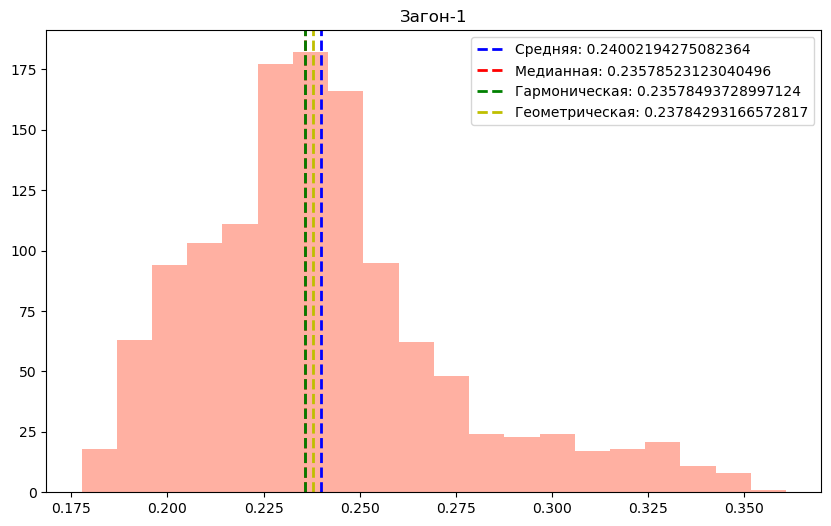

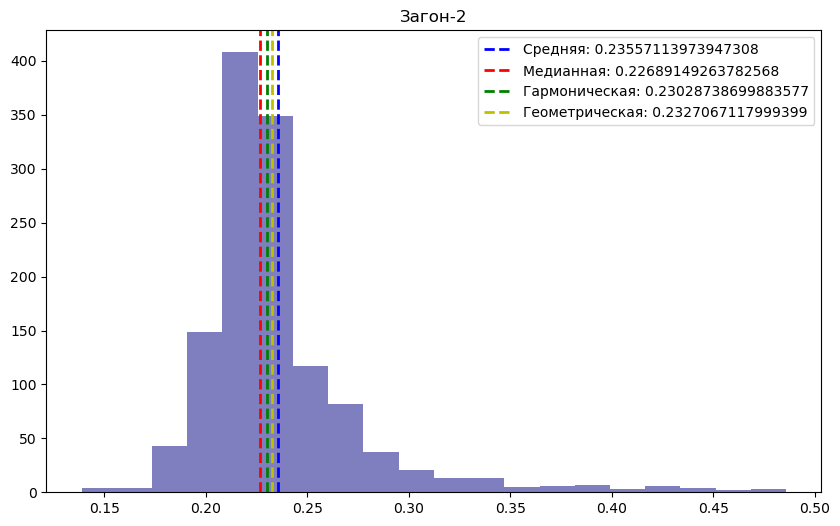

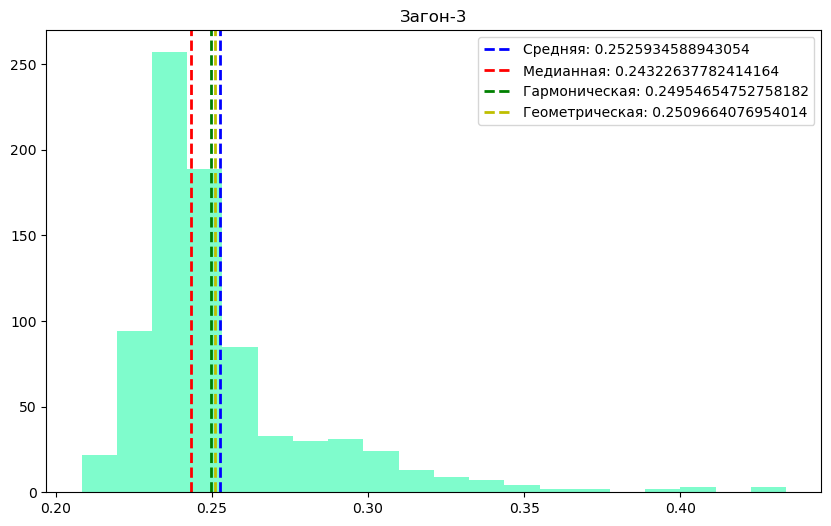

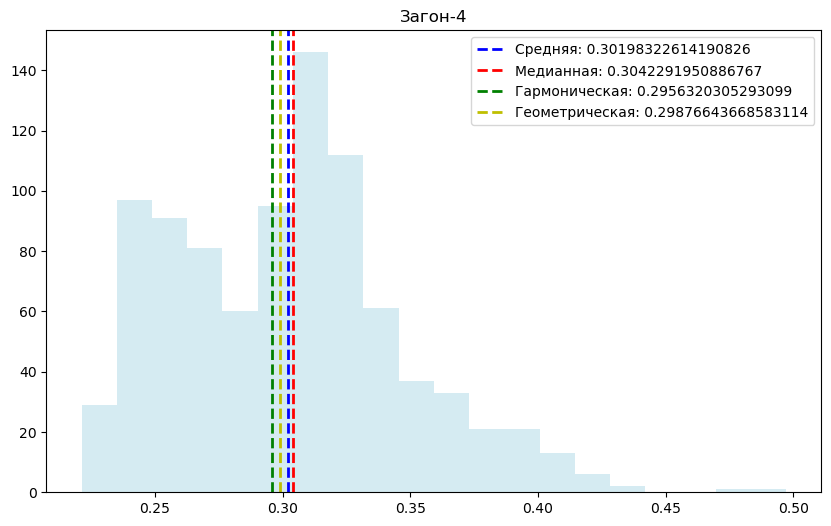

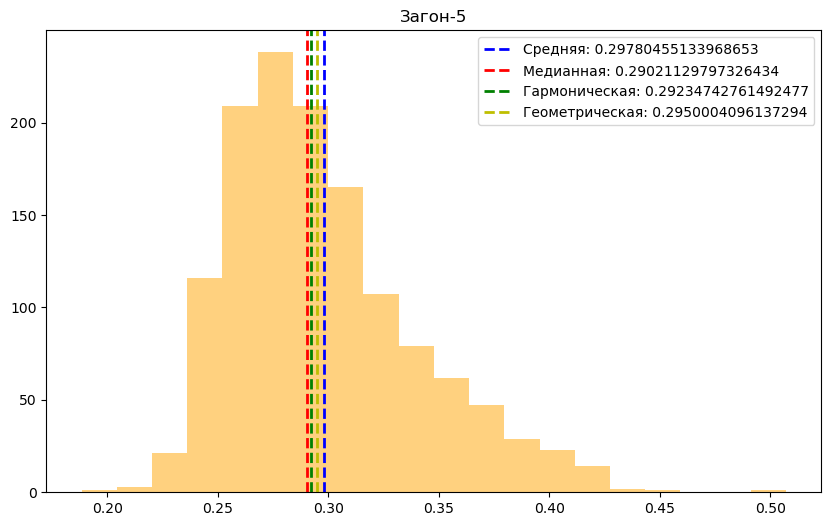

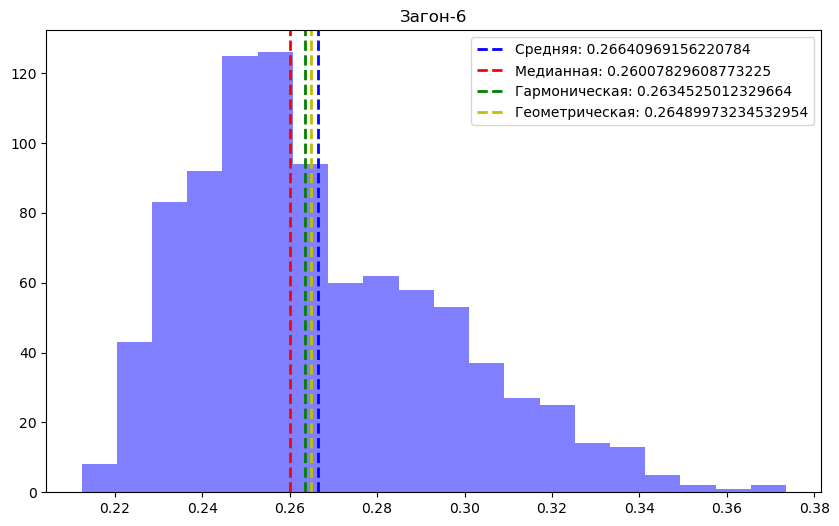

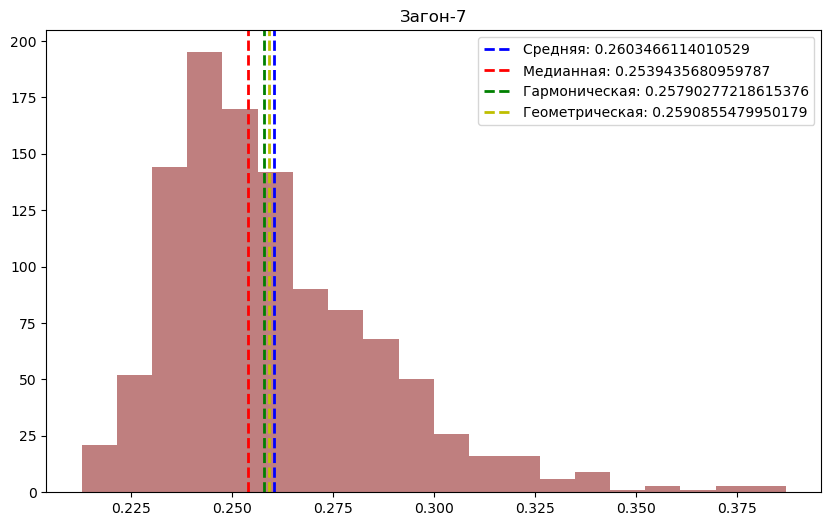

In [25]:
for i, zagon in enumerate(ndvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(ndvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(ndvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(hmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
    plt.axvline(gmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
    plt.legend([f"Средняя: {ndvi_masked_array[i].mean()}",f"Медианная: {ma.median(ndvi_masked_array[i])}",f"Гармоническая: {hmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height))}"])    
plt.show()

# Soil Adjusted Vegetation Index (SAVI)

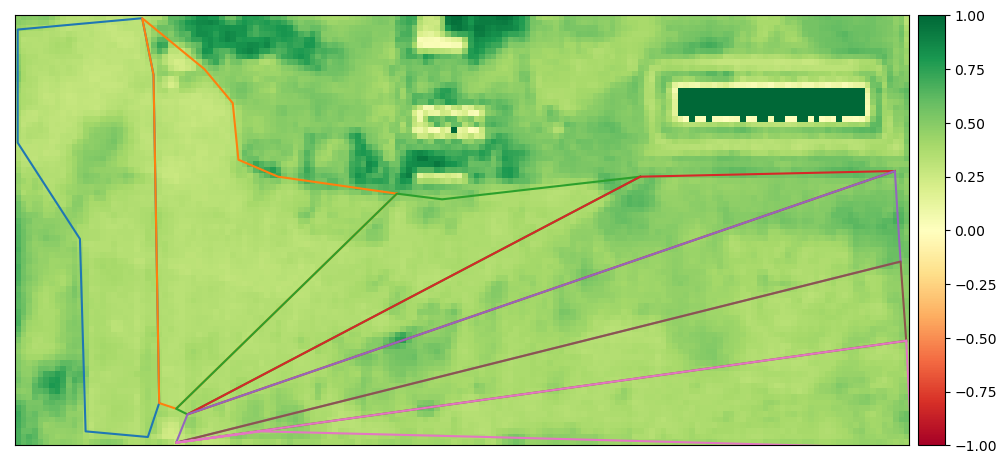

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

L = 0.5
savi = ((aoi_bands_stack[bands_dict["B08"]] - aoi_bands_stack[bands_dict["B04"]]) / (aoi_bands_stack[bands_dict["B08"]] + aoi_bands_stack[bands_dict["B04"]] + L)) * (1 + L)

ep.plot_bands(savi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [27]:
savi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(savi, mask=mask.reshape(aoi_height, aoi_width))
    savi_masked_array.append(mx)

# Статистические средние значения по загонам 

In [28]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Среднее значение SAVI: ", savi_masked_array[zagon].mean())

Загон №1. Среднее значение SAVI:  0.3599934879408924
Загон №2. Среднее значение SAVI:  0.3533200124607334
Загон №3. Среднее значение SAVI:  0.37885020843066974
Загон №4. Среднее значение SAVI:  0.4529254695377491
Загон №5. Среднее значение SAVI:  0.44665882827532244
Загон №6. Среднее значение SAVI:  0.3995710354487033
Загон №7. Среднее значение SAVI:  0.3904769123225868


In [29]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Медианное значение SAVI: ", ma.median(savi_masked_array[zagon]))

Загон №1. Медианное значение SAVI:  0.35364348527512335
Загон №2. Медианное значение SAVI:  0.3403014686160697
Загон №3. Медианное значение SAVI:  0.364801390499586
Загон №4. Медианное значение SAVI:  0.4562919176992156
Загон №5. Медианное значение SAVI:  0.43527002263662823
Загон №6. Медианное значение SAVI:  0.3900751721187881
Загон №7. Медианное значение SAVI:  0.3808730423192269


In [30]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Гармоническое среднее значение SAVI: ", hmean(savi_masked_array[zagon].reshape(aoi_width * aoi_height)))

Загон №1. Гармоническое среднее значение SAVI:  0.35363826223538514
Загон №2. Гармоническое среднее значение SAVI:  0.34539505373371593
Загон №3. Гармоническое среднее значение SAVI:  0.37428024589917736
Загон №4. Гармоническое среднее значение SAVI:  0.4433997328924376
Загон №5. Гармоническое среднее значение SAVI:  0.438473809242244
Загон №6. Гармоническое среднее значение SAVI:  0.39513560192187963
Загон №7. Гармоническое среднее значение SAVI:  0.38681139317629193


In [31]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Геометрическое среднее значение SAVI: ", gmean(savi_masked_array[zagon].reshape(aoi_width * aoi_height)))

Загон №1. Геометрическое среднее значение SAVI:  0.35672512747458796
Загон №2. Геометрическое среднее значение SAVI:  0.34902373969980344
Загон №3. Геометрическое среднее значение SAVI:  0.3764098458477874
Загон №4. Геометрическое среднее значение SAVI:  0.44810080988500844
Загон №5. Геометрическое среднее значение SAVI:  0.4424529508771932
Загон №6. Геометрическое среднее значение SAVI:  0.39730627538645574
Загон №7. Геометрическое среднее значение SAVI:  0.38858543811115


# Гистограмма SAVI по загонам
### Синяя - среднее значение. Красная - медианное значение
### Желтая - Геометрическая средняя. Зеленая - Гармоническая средняя

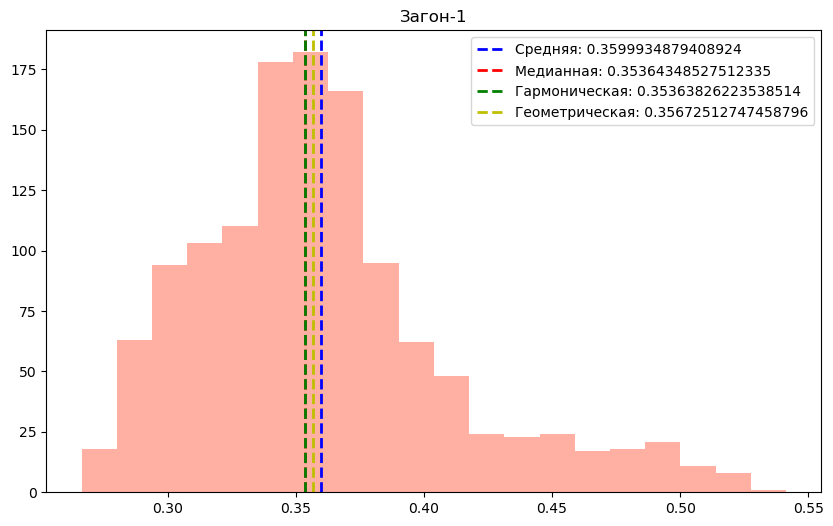

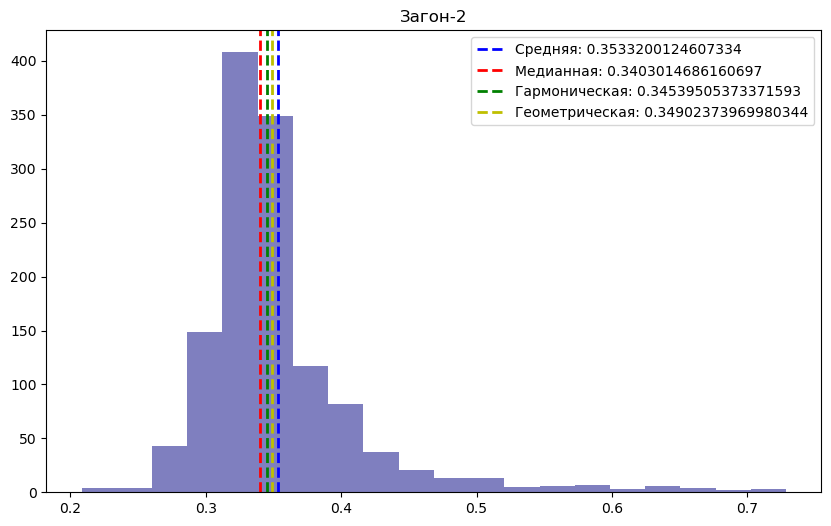

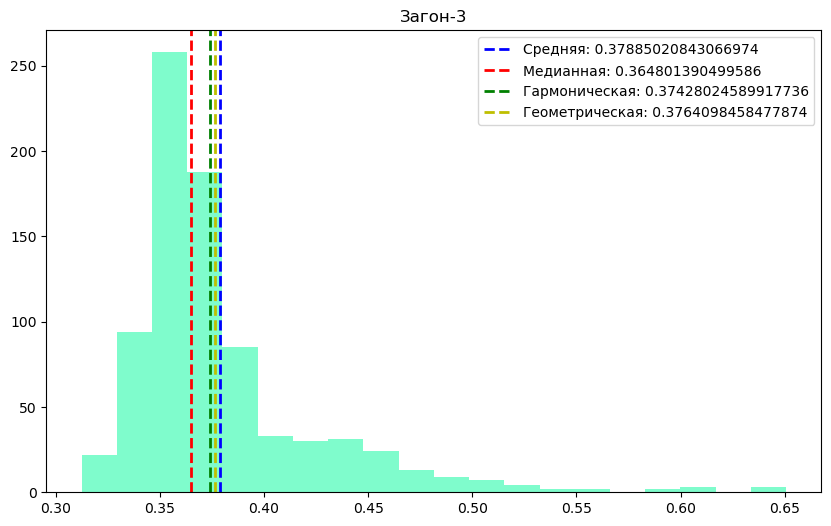

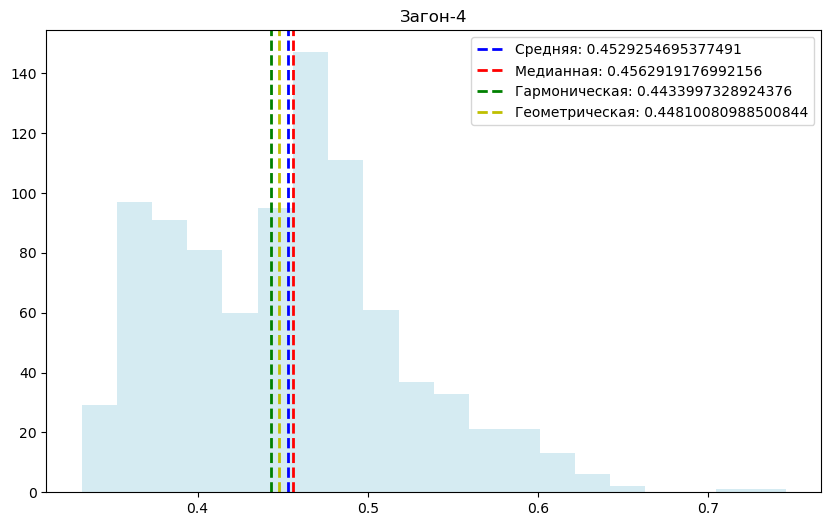

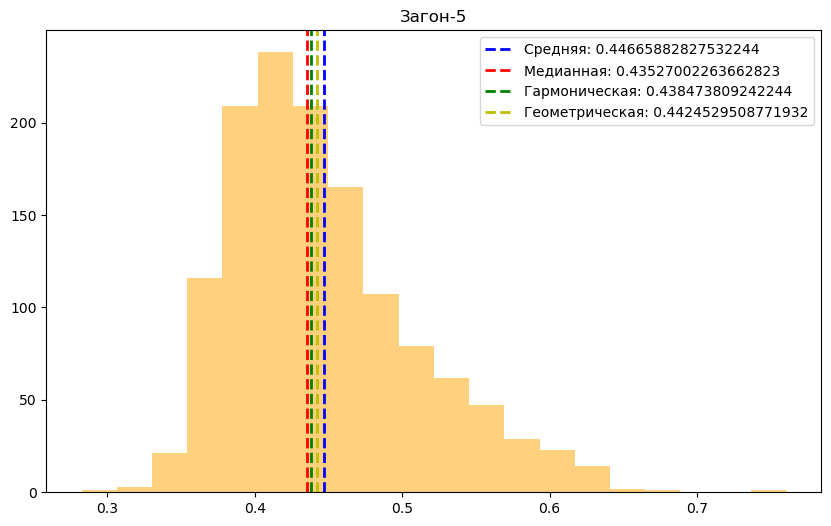

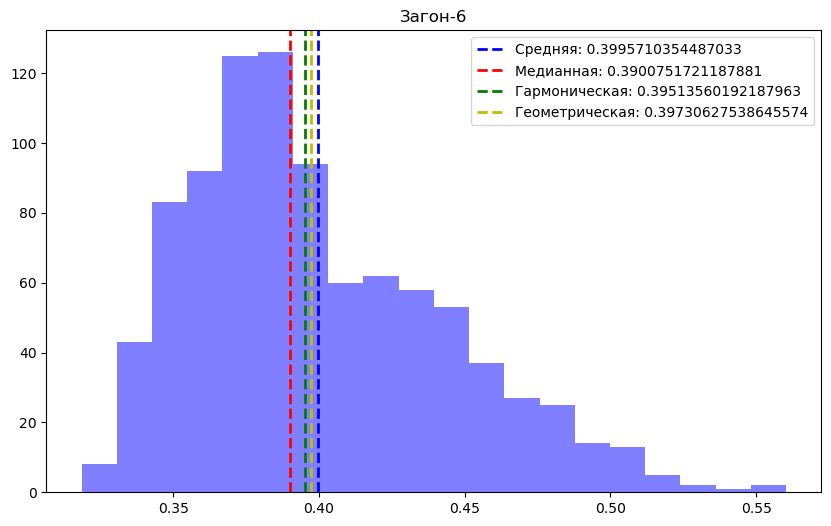

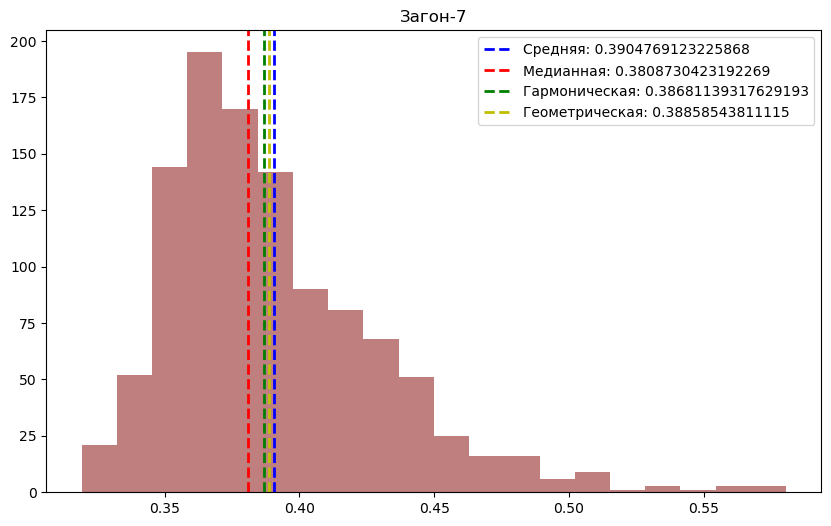

In [32]:
for i, zagon in enumerate(savi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(savi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(savi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(hmean(savi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
    plt.axvline(gmean(savi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
    plt.legend([f"Средняя: {savi_masked_array[i].mean()}",f"Медианная: {ma.median(savi_masked_array[i])}",f"Гармоническая: {hmean(savi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(savi_masked_array[i].reshape(aoi_width * aoi_height))}"])
plt.show()

# Анализ полученных данных

## Применение формул для определения урожайности

### Ссылка на статью: https://www.sciencedirect.com/science/article/pii/S0034425718304486

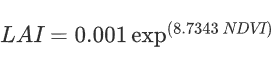

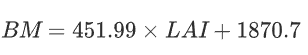

In [33]:
NDVI = 0.19  # Среднее значение NDVI для загона 
LAI = 0.001 * e**(8.7343 * NDVI)
BM = 451.99 * LAI + 1870.7 # килограмм/гектар

In [34]:
print(BM, "кг/га")

1873.0760080195153 кг/га


In [35]:
analysis = pd.read_excel('excel_data.xlsx', 0)
analysis

,Урожай.,Проек. пок.,Выс. раст.,NDVI сред. знач.,NDVI мед. Знач.,NDVI гарм. сред.,NDVI геомет. сред.,SAVI сред. Знач.,SAVI мед. знач.,SAVI гарм. сред.,SAVI геомет. сред.
0,0.42,41.85,9.01,0.21590,0.20697,0.21293,0.21435,0.32382,0.31041,0.31936,0.32149
1,0.60,80.80,14.90,0.26223,0.25901,0.26011,0.26116,0.39330,0.38848,0.39013,0.39170


In [36]:
corr = analysis.corr(method='pearson', min_periods=2)
corr.style.background_gradient(cmap='coolwarm')

,Урожай.,Проек. пок.,Выс. раст.,NDVI сред. знач.,NDVI мед. Знач.,NDVI гарм. сред.,NDVI геомет. сред.,SAVI сред. Знач.,SAVI мед. знач.,SAVI гарм. сред.,SAVI геомет. сред.
Урожай.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Проек. пок.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Выс. раст.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NDVI сред. знач.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NDVI мед. Знач.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NDVI гарм. сред.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NDVI геомет. сред.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SAVI сред. Знач.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SAVI мед. знач.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SAVI гарм. сред.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'Урожай')

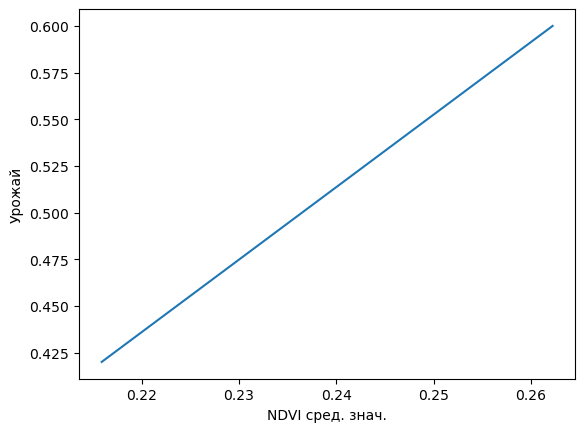

In [37]:
plt.plot(analysis["NDVI сред. знач."], analysis["Урожай."])

plt.xlabel("NDVI сред. знач.")
plt.ylabel("Урожай")

In [38]:
real = analysis.iloc[:, [0,1,2]]
dzz = analysis.iloc[:, [3,4,5,6,7,8,9,10]]

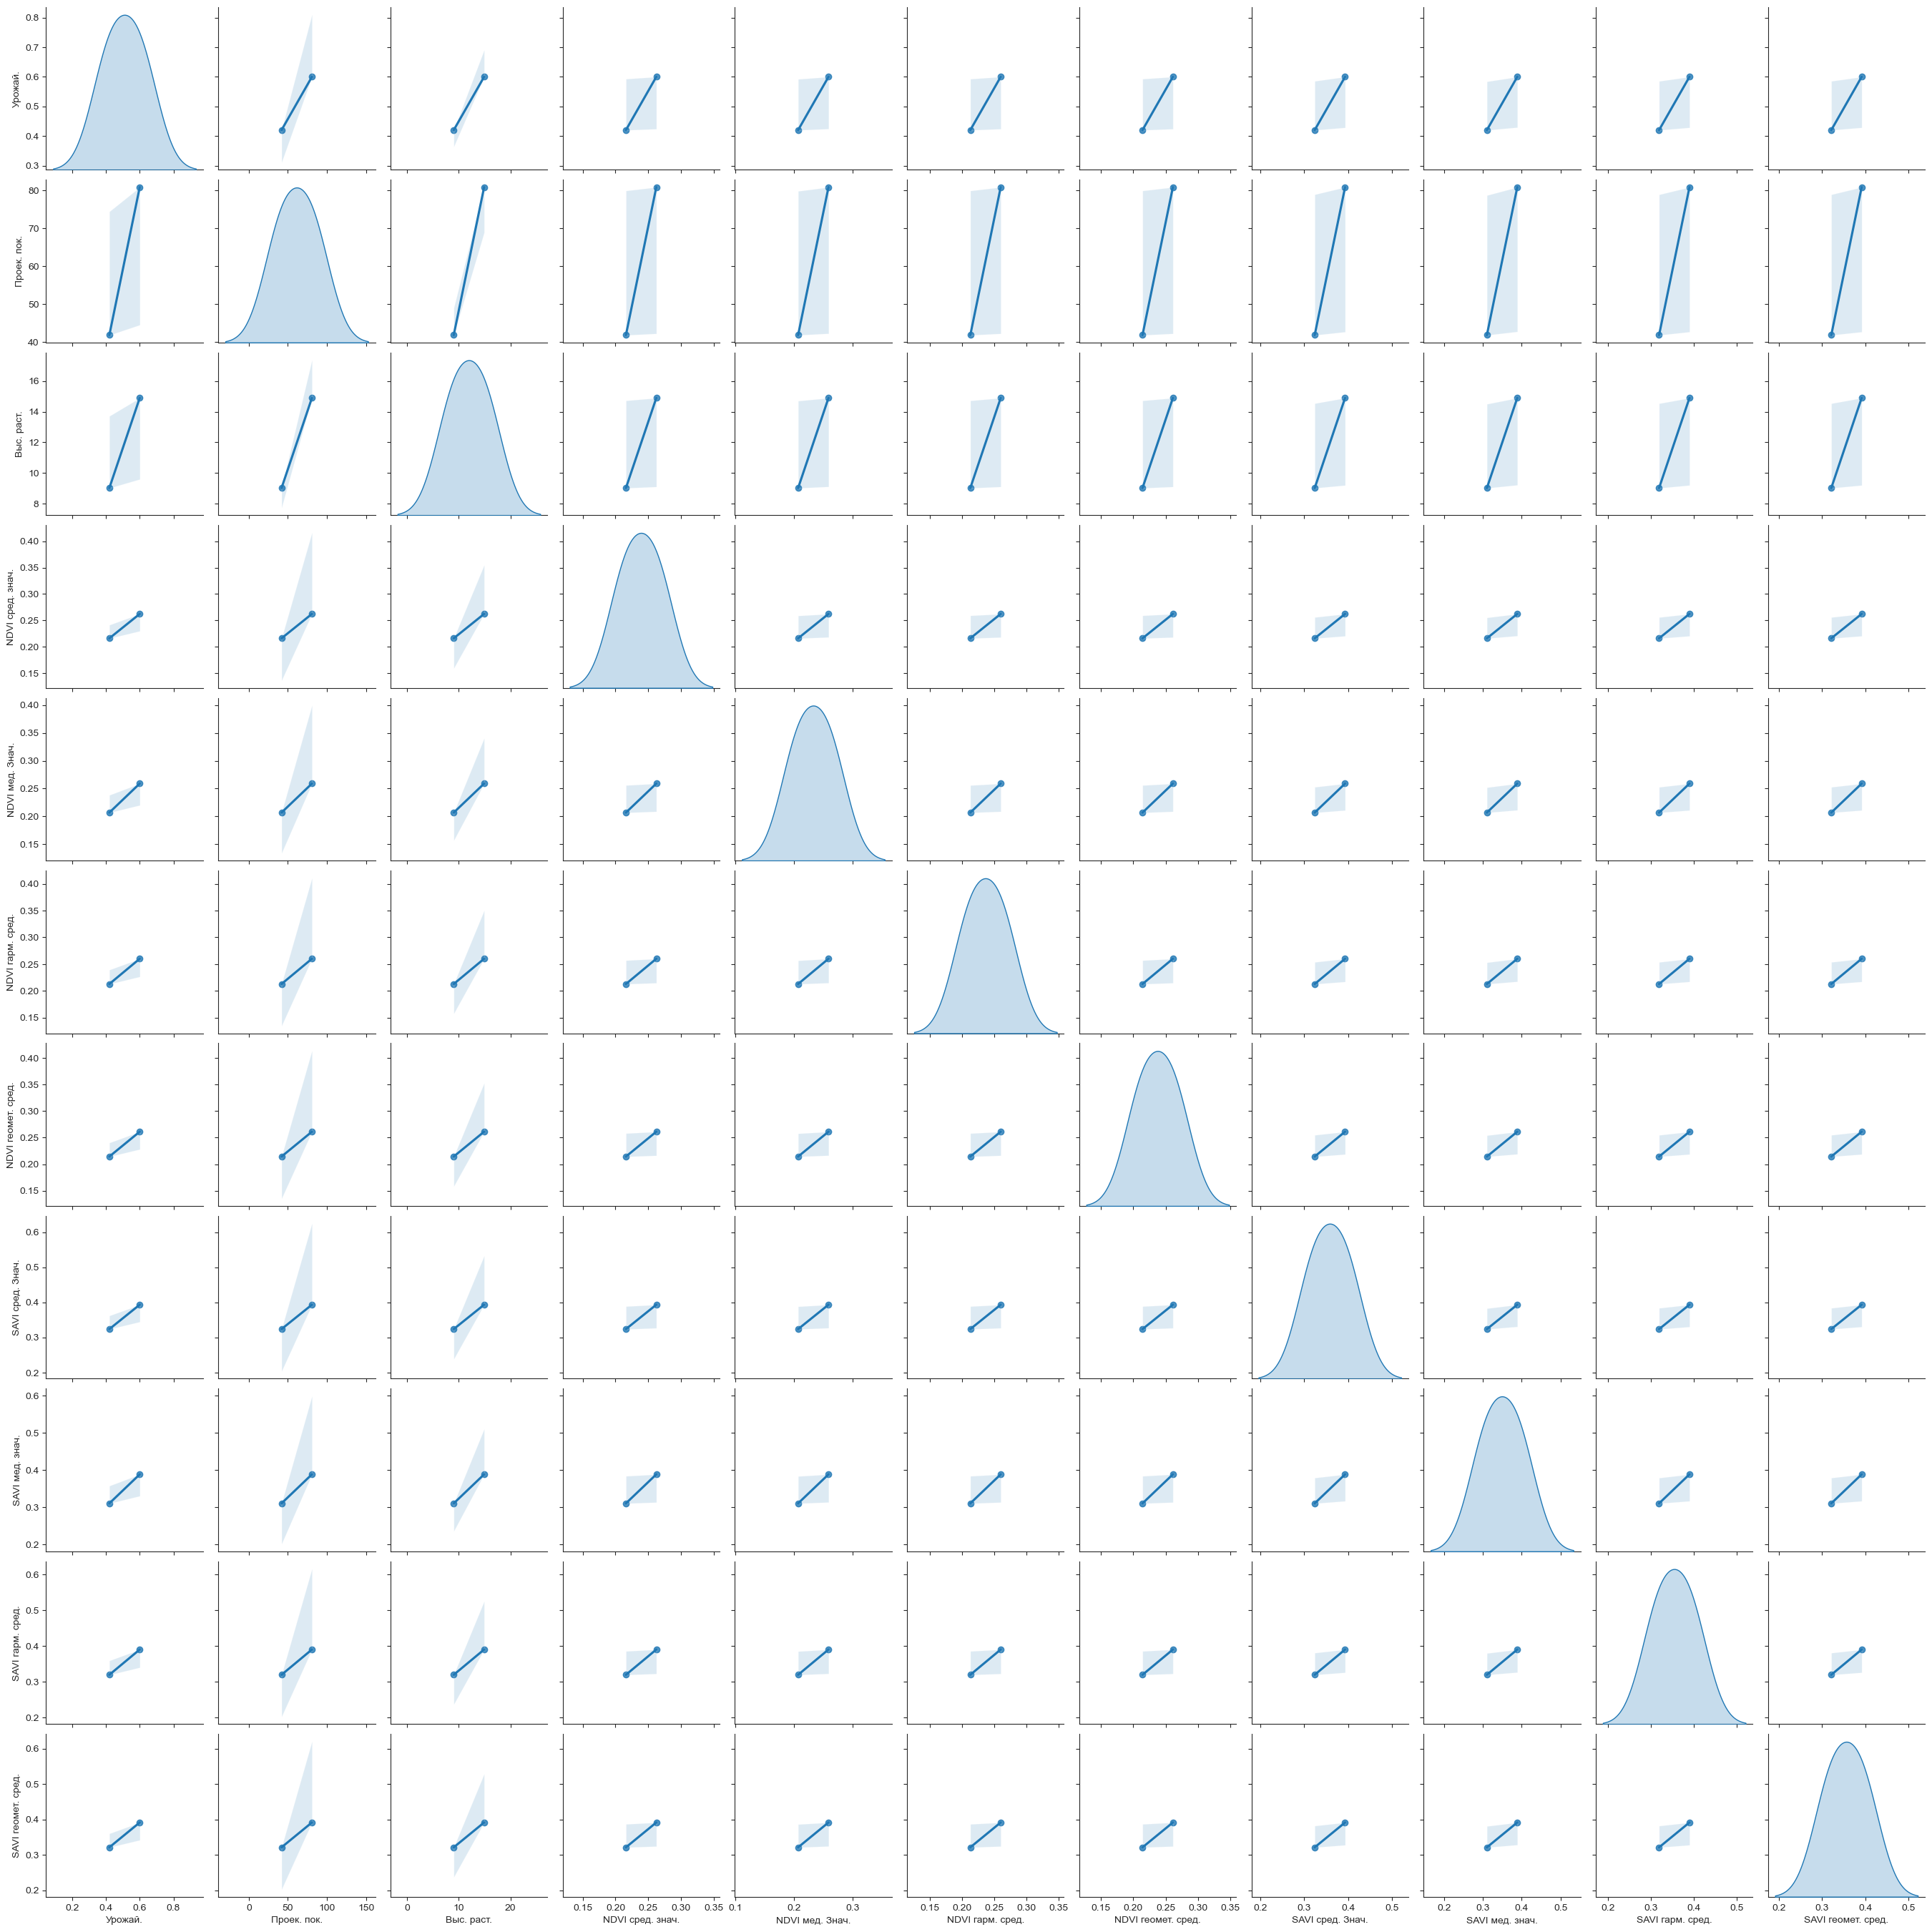

In [39]:
sns.set_style("ticks")
sns.pairplot(analysis, diag_kind = "kde", kind = "reg", palette = "husl")
plt.show()